# Quest 2 of Exploration 
## Kaggle Korea (Ka-Kr) Housing price prediction 
### Task: Regression task

- [ ] 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
- [ ] 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
- [ ] 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost 
import lightgbm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

1.4.2
3.3.0
0.5.0
1.0


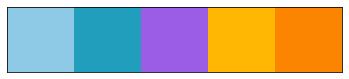

In [3]:
#Custom Color Palette 🎨
# From the Kaggle https://www.kaggle.com/code/devsubhash/tps-august-eda-failure-prediction
custom_colors = ["#8ecae6","#219ebc","#9b5de5","#ffb703","#fb8500"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors),size=1.2)
plt.tick_params(axis='both', labelsize=0, length = 0)

In [4]:
os.getcwd()

'/aiffel/aiffel/AIFFEL_Quest/EX_2'

In [5]:
train_data_path = join('../../kaggle_kakr_housing/data', 'train.csv')
sub_data_path = join('../../kaggle_kakr_housing/data', 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [6]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [8]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


<AxesSubplot:>

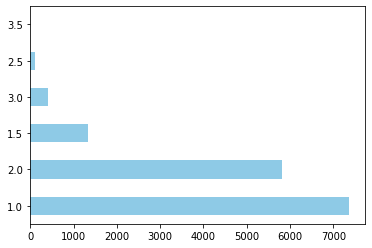

In [9]:
data['floors'].value_counts().plot(kind='barh') # floors - not-integer

# Data (features)
1. Important, basic statistics are shown below
2. using `groupby` method to see the effect, more carefully
- i.e. Effect of `view` on the price using `groupby`
3. Can have visualization 

### Data visualization

<AxesSubplot:xlabel='bedrooms,bathrooms'>

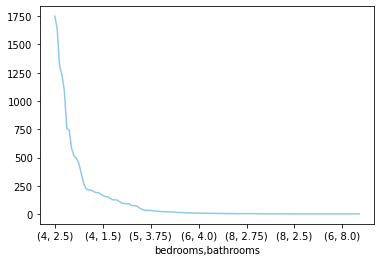

In [10]:
data.loc[:,['bedrooms','bathrooms']].value_counts().plot() # (4 bedrooms with 2.5 bathrooms are most appearing combination)

**Find up the potential categorical variables**

In [11]:
def parse_categorical_variables(df:pd.DataFrame, cat_no = 10):
    """
    Parse out potential categorical columns from integer columns.
    Input: pandas dataframe
    output: columns names that meet the conditions based on cat_no (default 10)
    """
    integer_columns = df.select_dtypes(include="integer").columns #select data type of integer
    cat_bucket = [] # empty list to take out column names
    for i in integer_columns:
        if len(np.unique(df[i])) <= cat_no:
            print(f"{i} may be valid columns that can be converted to categorical columns")
            cat_bucket.append(i)
        else:
            continue
    return(cat_bucket)

In [12]:
parse_categorical_variables(data)

waterfront may be valid columns that can be converted to categorical columns
view may be valid columns that can be converted to categorical columns
condition may be valid columns that can be converted to categorical columns


['waterfront', 'view', 'condition']

In [13]:
data.groupby(['waterfront', 'view', 'condition'], as_index = False)['price'].median().sort_values(by= 'price', ascending = False)

,waterfront,view,condition,price
23,1,2,3,7062500.0
22,1,2,2,2555000.0
28,1,3,5,2425000.0
32,1,4,5,1700000.0
31,1,4,4,1656000.0
30,1,4,3,1612500.0
20,0,4,5,1325800.0
18,0,4,3,1110000.0
16,0,3,5,1050500.0
26,1,3,3,1035000.0


In [14]:
data.groupby(['waterfront', 'view', 'condition'], as_index = False)['price'].agg(['count','min','mean','max'])

count        min          mean        max
waterfront view condition                                           
0          0    1             18    78000.0  2.557472e+05   575000.0
                2            106    80000.0  3.026609e+05  1200000.0
                3           8922    83000.0  5.019211e+05  5570000.0
                4           3500    89000.0  4.750934e+05  3000000.0
                5           1002   110000.0  5.449367e+05  3300000.0
           1    1              1   295000.0  2.950000e+05   295000.0
                3            136   217000.0  8.056253e+05  3650000.0
                4             78   239000.0  7.271289e+05  1959000.0
                5             25   350000.0  9.002220e+05  2250000.0
           2    2              1   370000.0  3.700000e+05   370000.0
                3            390   169317.0  7.779985e+05  2900000.0
                4            198   215000.0  7.852232e+05  3800000.0
                5             71   192500.0  9.125590e+05  2795000.0
           3    2              2   308130.0  3.840650e+05   460000.0
                3            222   154000.0  9.640971e+05  3204000.0
                4            105   280950.0  1.013641e+06  7700000.0
                5             30   262500.0  1.058004e+06  2250000.0
           4    1              1   252000.0  2.520000e+05   252000.0
                3             63   400000.0  1.383340e+06  6885000.0
                4             41   325000.0  1.106871e+06  3100000.0
                5             16   950000.0  1.497975e+06  3065000.0
1          1    4              1   635000.0  6.350000e+05   635000.0
           2    2              1  2555000.0  2.555000e+06  2555000.0
                3              1  7062500.0  7.062500e+06  7062500.0
                4              1   800000.0  8.000000e+05   800000.0
                5              2   340000.0  6.437500e+05   947500.0
           3    3              6   340000.0  1.012500e+06  1875000.0
                4              6   385000.0  6.861667e+05   999000.0
                5              2  1900000.0  2.425000e+06  2950000.0
           4    1              1   658000.0  6.580000e+05   658000.0
                3             53   285000.0  1.758177e+06  5110800.0
                4             26   480000.0  1.880688e+06  5300000.0
                5              7   429592.0  1.786370e+06  3650000.0

- Having waterfront does contribute to the pricing
- We now know that houses with view,condition = [2,2] are generally expensive compared to others. However, there are only two counts. 
- Second method using `groupby` serves better: however, it is diffuult to see if we can create new feature based on the categorical variables.   
`Further data visualization requred` --> difficult to find suitable visualization for this purpose

<AxesSubplot:xlabel='condition', ylabel='price'>

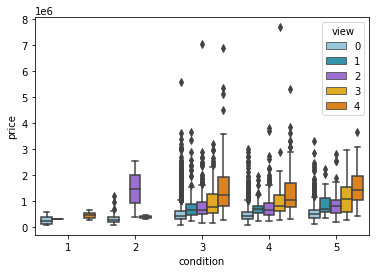

In [15]:
sns.boxplot(data = data, x= 'condition', y='price', hue = 'view') # View does contribute to the price. Higher the view, more expensive the price is

**Multiple plotting**

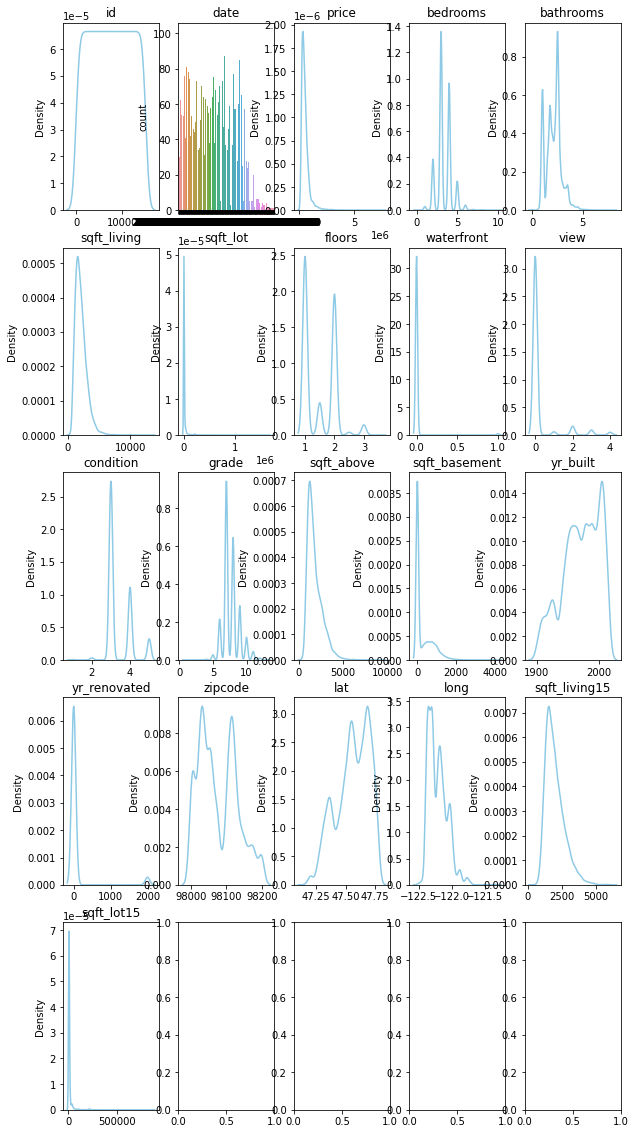

In [16]:
# Citation: https://www.kaggle.com/code/rizkykiky/need-eda-to-understand
f, axes = plt.subplots(5, 5, figsize = (10, 20))
for col, ax in zip(data.columns, axes.ravel()) :
    _ = sns.kdeplot(data[col], ax = ax) if not data[col].dtypes == 'object' else sns.countplot(data[col], ax = ax)
    ax.set_xlabel('')
    ax.set_title(col)
f.show()

In [17]:
# I think `lat` and `long` have more meaning than zipcode 


- Price (target variable) is positively skewed. --> I think we better transform the target variable
    - Citation: [scikit-learn article on regression](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html)

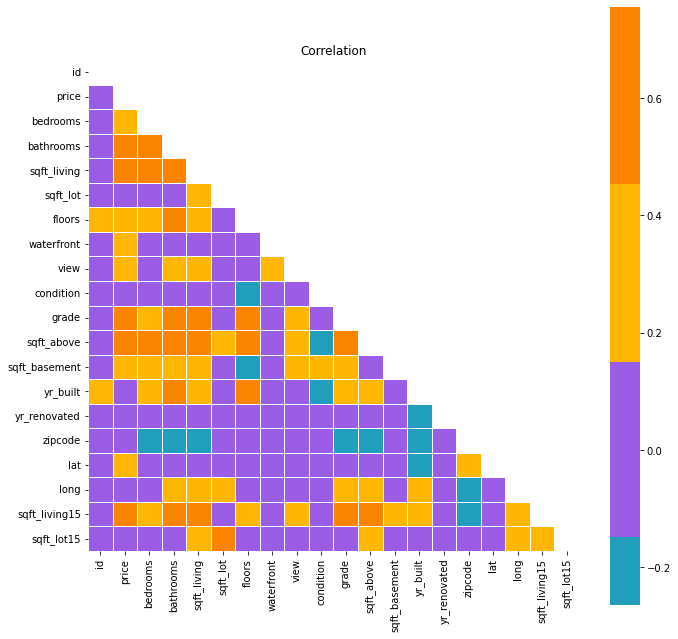

In [18]:
# Correlation plot
plt.figure(figsize=(11,11))
corr=data.corr() # correlation
mask = np.triu(np.ones_like(corr, dtype=bool)) #np.ones_like with same size as corr. Create triangular matrix
sns.heatmap(corr, mask=mask, cmap=custom_colors, robust=True, center=0,square=True, linewidths=.6)
plt.title('Correlation')
plt.show()

- Lat has a weak correlation with price. Negative correlation with `yr_built`

In [19]:
data[['yr_renovated','yr_built']] # yr_renovated 0 --> houses that have not undergone 

,yr_renovated,yr_built
0,0,1955
1,0,1933
2,0,1987
3,0,1995
4,0,1963
...,...,...
15030,0,2014
15031,0,2009
15032,0,2009
15033,0,2014


In [20]:
data[data['yr_renovated'] != 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
26,26,20140613T000000,696000.0,3,2.50,2300,3060,1.5,0,0,...,8,1510,790,1930,2002,98115,47.6827,-122.310,1590,3264
78,78,20141121T000000,740500.0,3,3.50,4380,6350,2.0,0,0,...,8,2780,1600,1900,1999,98117,47.6981,-122.368,1830,6350
149,149,20150221T000000,1505000.0,5,3.00,3300,33474,1.0,0,3,...,9,1870,1430,1957,1991,98040,47.5673,-122.210,3836,20953
160,160,20150413T000000,655000.0,2,1.75,1450,15798,2.0,1,4,...,7,1230,220,1915,1978,98166,47.4497,-122.375,2030,13193
166,166,20150320T000000,410000.0,4,1.00,1970,4740,1.5,0,0,...,7,1670,300,1904,2005,98122,47.6136,-122.303,1510,4740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13626,13626,20141104T000000,257000.0,3,1.75,1397,18000,1.0,0,0,...,7,1397,0,1965,2014,98092,47.3388,-122.166,1950,31294
13641,13641,20140712T000000,451000.0,2,1.00,900,6000,1.0,0,0,...,7,900,0,1944,2004,98115,47.6855,-122.289,1460,4800
13952,13952,20140904T000000,434900.0,3,2.00,1520,5040,2.0,0,0,...,7,1520,0,1977,2006,98177,47.7770,-122.362,1860,8710
14218,14218,20150225T000000,500012.0,4,2.50,2400,9612,1.0,0,0,...,8,1230,1170,1962,2009,98059,47.4799,-122.127,2430,5539


### Preprocessing: 
1. Missing value operation (Checking, imputation, etc.)
- using `missingno` package to visualize mssing data

### Feature engineering: `yr_built`, `yr_renovated` , `date`
- Feature engineering needs to be done against whole dataset, including "test" dataset
- [ ] is_renovated: if `yr_renovated` is 0, then replace with False else True 
- [ ] the rows: `is_renovated` is true, then create a row `yr_renovated` - `yr_built` with feature name "house_age". Else calculate the difference between bought (i.e. date) and `yr_built`
- but before that, `id` and `date` need to be arranged
    - removal of `id` 
    - Make categorical variables regarding year/month out of `date`
- also log transformation will be applied

In [21]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)
sub_id = data['id'][train_len:]
del data['id'] # Erase ID column
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str) # year/month only

In [22]:
y = np.log1p(data['price']) # log transformation because below kernel shows that it's skewed
del data['price']

<AxesSubplot:>

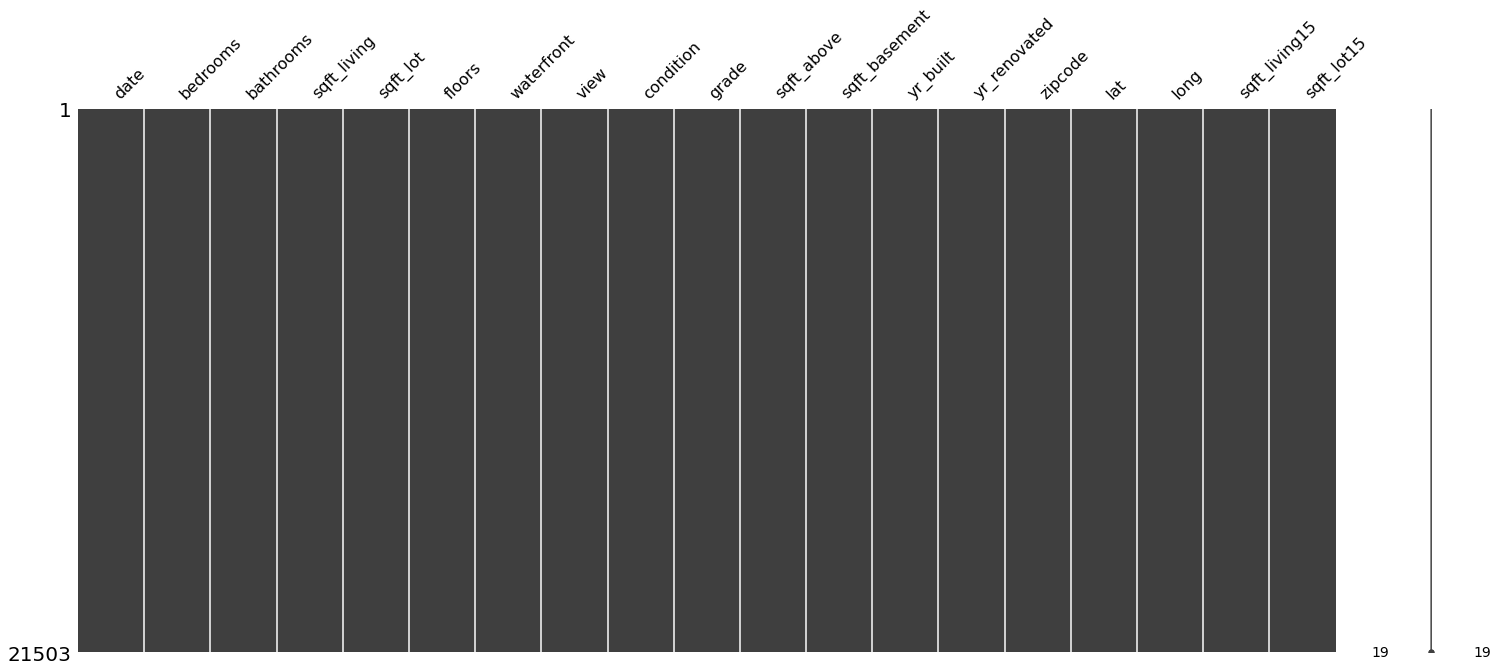

In [23]:
msno.matrix(data)

In [24]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [25]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values))) #checking if there is missing value

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [26]:
data = data.reset_index(drop = True)

In [27]:
len(data.columns)

19

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

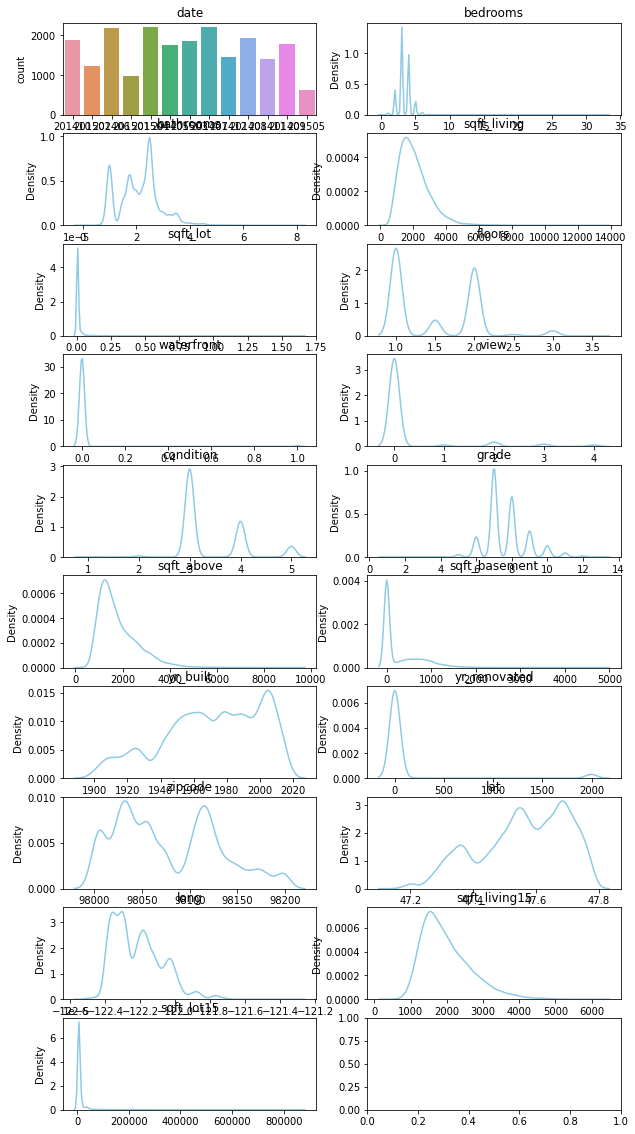

In [28]:
# Citation: https://www.kaggle.com/code/rizkykiky/need-eda-to-understand
f, axes = plt.subplots(10, 2, figsize = (10, 20))
for col, ax in zip(data.columns, axes.ravel()) : #column-axes 
    _ = sns.kdeplot(data[col], ax = ax) if not data[col].dtypes == 'object' else sns.countplot(data[col], ax = ax)
    ax.set_xlabel('')
    ax.set_title(col)
f.show()

skweness was seen in `price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement` <br>
will do log-scaling

In [29]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

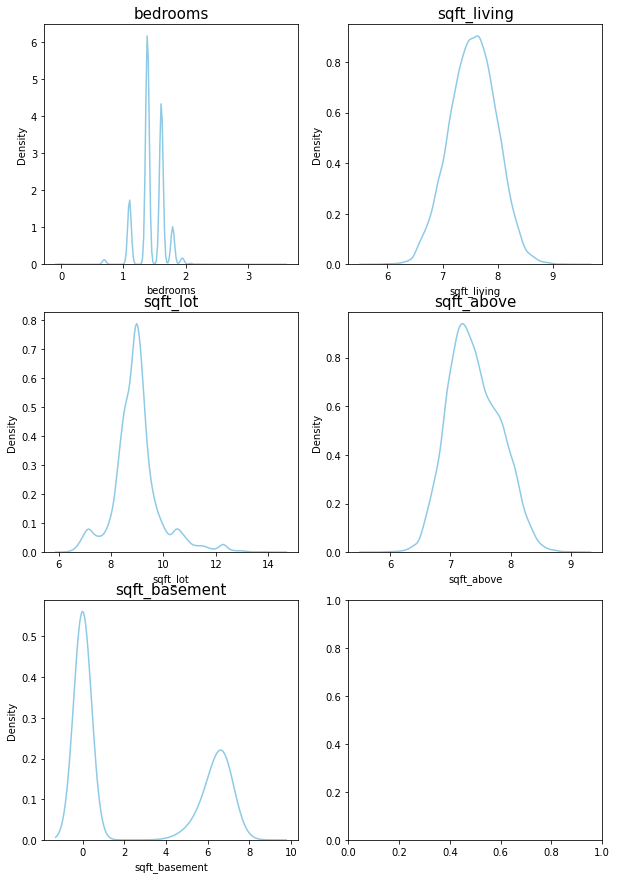

In [30]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

In [31]:
(data['yr_renovated'] != 0).astype('boolean').value_counts()

False    20590
True       913
Name: yr_renovated, dtype: Int64

In [32]:
data['is_renovated'] = (data['yr_renovated'] != 0).astype('boolean')  # renovation

In [33]:
data['is_renovated'].value_counts()

False    20590
True       913
Name: is_renovated, dtype: Int64

In [34]:
ind_not_renovated = data[data['is_renovated'] == False].index

In [35]:
data['year'] = data['date'].apply(lambda date: str(date)[:4])

In [36]:
data['year']

0        2014
1        2015
2        2015
3        2014
4        2015
         ... 
21498    2014
21499    2015
21500    2015
21501    2014
21502    2015
Name: year, Length: 21503, dtype: object

In [37]:
data['month'] = data['date'].apply(lambda date: str(date)[4:6])

In [38]:
data.loc[ind_not_renovated,'year']

0        2014
1        2015
2        2015
3        2014
4        2015
         ... 
21498    2014
21499    2015
21500    2015
21501    2014
21502    2015
Name: year, Length: 20590, dtype: object

In [39]:
data['year'] = data['year'].astype(float)

In [40]:
data.loc[ind_not_renovated,'yr_built']

0        1955
1        1933
2        1987
3        1995
4        1963
         ... 
21498    2014
21499    2014
21500    2008
21501    2009
21502    2004
Name: yr_built, Length: 20590, dtype: int64

In [41]:
data.loc[ind_not_renovated, 'house_age'] = data.loc[ind_not_renovated, 'year'] - data.loc[ind_not_renovated,'yr_built']

In [42]:
data['house_age']

0        59.0
1        82.0
2        28.0
3        19.0
4        52.0
         ... 
21498     0.0
21499     1.0
21500     7.0
21501     5.0
21502    11.0
Name: house_age, Length: 21503, dtype: float64

In [43]:
ind_renovated = data[data['is_renovated'] == True].index #house_age for renovated houses is determined from date bought - yr_renovated

In [44]:
data.loc[ind_renovated, 'house_age'] = data.loc[ind_renovated, 'year'] - data.loc[ind_renovated,'yr_built']

In [45]:
data['house_age']

0        59.0
1        82.0
2        28.0
3        19.0
4        52.0
         ... 
21498     0.0
21499     1.0
21500     7.0
21501     5.0
21502    11.0
Name: house_age, Length: 21503, dtype: float64

In [46]:
columns_to_drop = ['month', 'year', 'date']

In [47]:
data.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'is_renovated', 'year', 'month',
       'house_age'],
      dtype='object')

In [48]:
data = data.drop(columns_to_drop, axis =1)

In [49]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

In [50]:
y[:train_len]

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [51]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgboost.XGBRegressor(random_state=2019)
lightgbm = lightgbm.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [52]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019, shuffle = True).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y[:train_len])), 
                                             kf=kfold))

In [53]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8771
Model XGBoost CV score : 0.8947
Model LightGBM CV score : 0.8999


### Grid Search CV
> Search up the best hyperparameters by thinking of all the possibilities 

In [57]:
from sklearn.model_selection import GridSearchCV
import xgboost 
import lightgbm

In [55]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [58]:
lightgbm = lightgbm.LGBMRegressor(random_state=2019)

In [59]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV model
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # Model fitting
    grid_model.fit(train, y)

    # Save the results
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # Dataframe 
    results = pd.DataFrame(params)
    results['score'] = score
    
    # Calculate and re-arrange the RMSLE
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [60]:
results = my_GridSearch(lightgbm, train = x.values, y= y[:train_len], param_grid = param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [61]:
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027748,0.166579
2,10,50,-0.029731,0.172426
1,1,100,-0.055074,0.234678
0,1,50,-0.073398,0.270920


In [63]:
models

[{'model': GradientBoostingRegressor(random_state=2019),
  'name': 'GradientBoosting'},
 {'model': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=2019, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
  'name': 'XGBoost'},
 {'model': LGBMRegressor(random_state=2019), 'name': 'LightGBM'}]

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [65]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [66]:
models

[{'model': GradientBoostingRegressor(random_state=2019),
  'name': 'GradientBoosting'},
 {'model': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=2019, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
  'name': 'XGBoost'},
 {'model': LGBMRegressor(random_state=2019), 'name': 'LightGBM'}]

In [68]:
x

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,house_age
0,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,1340,5650,False,59.0
1,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,2720,8062,False,82.0
2,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,1800,7503,False,28.0
3,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,2238,6819,False,19.0
4,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,1650,9711,False,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,1.609438,2.50,7.832411,8.703507,2.0,0,0,3,9,7.832411,0.000000,2014,0,98056,47.5137,-122.167,2520,6023,False,0.0
15031,1.609438,3.50,8.163656,8.881975,2.0,0,0,3,9,7.863651,6.814543,2009,0,98136,47.5537,-122.398,2050,6200,False,6.0
15032,1.386294,2.50,7.333676,7.031741,3.0,0,0,3,8,7.333676,0.000000,2009,0,98103,47.6993,-122.346,1530,1509,False,5.0
15033,1.609438,2.50,7.745436,8.668024,2.0,0,0,3,8,7.745436,0.000000,2014,0,98146,47.5107,-122.362,1830,7200,False,1.0


In [70]:
y_pred = AveragingBlending(models, x, y[:train_len], sub) #price data only available in train

In [71]:
y_pred = np.expm1(y_pred)

In [72]:
y_pred

array([ 540624.71110321,  438686.00545877, 1369910.76625238, ...,
        455786.44087725,  331097.39039827,  446612.61903335])

In [73]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [74]:
sub.to_csv('submission.csv', index=False)

- Private: 117116.25688

- 회고록
    - Data visualization 부터 전처리 및 데이터 엔지니어링 (data feature 새로운 거 만들기) 너무 재미있었습니다. 
        - house_age column 만들기, plots 대량으로 한꺼번에 그리기
        - Model 만들기 부터 Blending 등 
    - 하지만 노드를 진행할 때는 시간 분배가 중요할것 같습니다